In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

In [2]:
api_token = {"username":"username","key":"key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [3]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

100% 148M/149M [00:08<00:00, 23.5MB/s]
100% 149M/149M [00:08<00:00, 18.9MB/s]


In [4]:
!unzip -qq brain-tumor-mri-dataset.zip

In [5]:
import tensorflow as tf

In [6]:
tf.keras.utils.set_random_seed(1234)

In [7]:
imagePaths = "Training"

In [8]:
testPaths = "Testing"

In [9]:
batch_size=64
img_height = 128
img_width = 128  

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths,
  color_mode='grayscale',
  #validation_split=0.0,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size) 

Found 5712 files belonging to 4 classes.


In [11]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  testPaths,
  color_mode='grayscale',
  #validation_split=0.0,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size) 

Found 1311 files belonging to 4 classes.


In [12]:
x_train= tf.concat([x for x, y in train_ds], axis=0)
y_train= tf.concat([y for x, y in train_ds], axis=0)
x_test= tf.concat([x for x, y in test_ds], axis=0)
y_test= tf.concat([y for x, y in test_ds], axis=0)

In [13]:
import numpy as np

In [14]:
from tensorflow import keras

In [15]:
import tensorflow as tf

In [16]:
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 128, 128, 1))
all_labels = keras.utils.to_categorical(all_labels, 4)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")


Shape of training images: (7023, 128, 128, 1)
Shape of training labels: (7023, 4)


In [17]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [18]:
from tensorflow.keras import layers
from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import imageio

In [19]:
batch_size = 64
num_channels = 1
num_classes = 4
image_size = 128
latent_dim = 128

In [20]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

132 5


In [21]:
# Create the discriminator.
inp= tf.keras.Input(shape=(128, 128, discriminator_in_channels))
x = layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same")(inp)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.GlobalMaxPooling2D()(x)
out = layers.Dense(1, activation="sigmoid")(x)
  
discriminator= tf.keras.Model(inputs=inp, outputs=out)

In [22]:
inp = tf.keras.Input(shape=(generator_in_channels,))
# We want to generate 128 + num_classes coefficients to reshape into a
# 7x7x(128 + num_classes) map.
x = layers.Dense(8 * 8 * generator_in_channels)(inp)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Reshape((8, 8, generator_in_channels))(x)
x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
out = layers.Conv2D(1, (8, 8), padding="same", activation="tanh")(x)
generator = tf.keras.Model(inputs=inp, outputs=out)

In [23]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [24]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

In [25]:
cond_gan.fit(dataset, epochs=600)

Epoch 1/600


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


110/110 [==============================] - 26s 98ms/step - g_loss: 1.3811 - d_loss: 0.6004
Epoch 2/600
110/110 [==============================] - 9s 81ms/step - g_loss: 1.2406 - d_loss: 0.7137
Epoch 3/600
110/110 [==============================] - 9s 81ms/step - g_loss: 3.4005 - d_loss: 0.1584
Epoch 4/600
110/110 [==============================] - 9s 81ms/step - g_loss: 3.7777 - d_loss: 0.1822
Epoch 5/600
110/110 [==============================] - 9s 81ms/step - g_loss: 6.7638 - d_loss: 9.6278e-04
Epoch 6/600
110/110 [==============================] - 9s 81ms/step - g_loss: 7.4970 - d_loss: 4.5801e-04
Epoch 7/600
110/110 [==============================] - 9s 82ms/step - g_loss: 7.8793 - d_loss: 0.0105
Epoch 8/600
110/110 [==============================] - 9s 81ms/step - g_loss: 2.9529 - d_loss: 0.7663
Epoch 9/600
110/110 [==============================] - 9s 82ms/step - g_loss: 3.8037 - d_loss: 0.2064
Epoch 10/600
110/110 [==============================] - 9s 82ms/step - g_loss: 6.1747

In [28]:
cond_gan.fit(dataset, epochs=100)

Epoch 1/100
110/110 [==============================] - 9s 83ms/step - g_loss: 1.4220 - d_loss: 0.4401
Epoch 2/100
110/110 [==============================] - 9s 81ms/step - g_loss: 1.5015 - d_loss: 0.4063
Epoch 3/100
110/110 [==============================] - 9s 81ms/step - g_loss: 1.4506 - d_loss: 0.4459
Epoch 4/100
110/110 [==============================] - 9s 81ms/step - g_loss: 1.4840 - d_loss: 0.4169
Epoch 5/100
110/110 [==============================] - 9s 81ms/step - g_loss: 1.4991 - d_loss: 0.4188
Epoch 6/100
110/110 [==============================] - 9s 81ms/step - g_loss: 1.4407 - d_loss: 0.4210
Epoch 7/100
110/110 [==============================] - 9s 81ms/step - g_loss: 1.5199 - d_loss: 0.4045
Epoch 8/100
110/110 [==============================] - 9s 82ms/step - g_loss: 1.5112 - d_loss: 0.4070
Epoch 9/100
110/110 [==============================] - 9s 82ms/step - g_loss: 1.5222 - d_loss: 0.4113
Epoch 10/100
110/110 [==============================] - 9s 82ms/step - g_loss: 1.5

In [31]:
cond_gan.fit(dataset, epochs=100)

Epoch 1/100
110/110 [==============================] - 9s 82ms/step - g_loss: 1.6925 - d_loss: 0.3451
Epoch 2/100
110/110 [==============================] - 9s 81ms/step - g_loss: 1.6813 - d_loss: 0.3563
Epoch 3/100
110/110 [==============================] - 9s 81ms/step - g_loss: 1.7518 - d_loss: 0.3935
Epoch 4/100
110/110 [==============================] - 9s 82ms/step - g_loss: 1.9481 - d_loss: 0.3045
Epoch 5/100
110/110 [==============================] - 9s 81ms/step - g_loss: 1.7695 - d_loss: 0.3393
Epoch 6/100
110/110 [==============================] - 9s 84ms/step - g_loss: 1.6768 - d_loss: 0.3372
Epoch 7/100
110/110 [==============================] - 9s 82ms/step - g_loss: 1.7191 - d_loss: 0.3403
Epoch 8/100
110/110 [==============================] - 9s 83ms/step - g_loss: 1.7067 - d_loss: 0.3460
Epoch 9/100
110/110 [==============================] - 9s 83ms/step - g_loss: 1.7388 - d_loss: 0.3340
Epoch 10/100
110/110 [==============================] - 9s 83ms/step - g_loss: 1.7

In [32]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 3  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 0  # @param {type:"slider", min:0, max:4, step:1}
end_class = 3  # @param {type:"slider", min:0, max:4, step:1}

fake_images = interpolate_class(start_class, end_class)

1/1 [==============================] - 0s 24ms/step


In [34]:
trained_gen.save("brain_gen.h5")


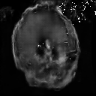

In [33]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images, fps=1)
embed.embed_file("animation.gif")